# MNIST

This notebook contains our experiements comparing forward gradient and backpropagation with neural networks and Convolutional nets for the MNIST dataset

#### Setup

In [1]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.7 MB 93 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220611+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220611+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220611+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

{'restart': True, 'status': 'ok'}

In [1]:
!git clone https://github.com/benjaminrike1/forward_gradient

Cloning into 'forward_gradient'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 76 (delta 31), reused 52 (delta 17), pack-reused 0
Unpacking objects: 100% (76/76), done.


In [2]:
cd forward_gradient

/content/forward_gradient


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD, ForwardAdam
from models import Net, ConvNet, LogisticRegression

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


ModuleNotFoundError: ignored

## MNIST

Importing the data from torchvision.

In [4]:
# transforming images to tensors
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


mnist_train = torchvision.datasets.MNIST(
    '/tmp/data',
    train=True, 
    download=True, 
    transform=transform
)

# splitting into training and validation set
train, val = torch.utils.data.random_split(mnist_train, [50000, 10000])

train_data_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=64, 
                                          shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val, 
                                          batch_size=64, 
                                          shuffle=True)

# loading test set
mnist_test = torchvision.datasets.MNIST(
    '/tmp/data',
    train=False, 
    download=True, 
    transform=transform
)
test_data_loader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=64,
                                              shuffle=True)

# Neural Network

We first use a vanilla feedforward network for the optimization. The net can be found in `models.py`

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
decays = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000001: 2.3024049260813717
Validation loss for lr = 0.000010, decay = 0.000010: 2.2973024814751497
Validation loss for lr = 0.000010, decay = 0.000100: 2.2996652141498153
Validation loss for lr = 0.000025, decay = 0.000001: 2.294420749518522
Validation loss for lr = 0.000025, decay = 0.000010: 2.291391800922953
Validation loss for lr = 0.000025, decay = 0.000100: 2.2962763840985145
Validation loss for lr = 0.000063, decay = 0.000001: 2.2722129396572233
Validation loss for lr = 0.000063, decay = 0.000010: 2.2714145836556794
Validation loss for lr = 0.000063, decay = 0.000100: 2.2774636350619564
Validation loss for lr = 0.000158, decay = 0.000001: 2.20808955210789
Validation loss for lr = 0.000158, decay = 0.000010: 2.2020661982761065
Validation loss for lr = 0.000158, decay = 0.000100: 2.2419782489728015
Validation loss for lr = 0.000398, decay = 0.000001: 1.348107600667674
Validation loss for lr = 0.000398, decay = 0.000010: 1.52265761080820

Searching for best learning rate and learning rate decay for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-4, -2, 6)
decays = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = Net().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.254
Validation loss for lr = 0.000100, decay = 0.000010: 2.249
Validation loss for lr = 0.000100, decay = 0.000000: 2.250
Validation loss for lr = 0.000251, decay = 0.000001: 2.126
Validation loss for lr = 0.000251, decay = 0.000010: 2.137
Validation loss for lr = 0.000251, decay = 0.000000: 2.123
Validation loss for lr = 0.000631, decay = 0.000001: 1.252
Validation loss for lr = 0.000631, decay = 0.000010: 1.306
Validation loss for lr = 0.000631, decay = 0.000000: 1.279
Validation loss for lr = 0.001585, decay = 0.000001: 0.486
Validation loss for lr = 0.001585, decay = 0.000010: 0.503
Validation loss for lr = 0.001585, decay = 0.000000: 0.492
Validation loss for lr = 0.003981, decay = 0.000001: 0.322
Validation loss for lr = 0.003981, decay = 0.000010: 0.326
Validation loss for lr = 0.003981, decay = 0.000000: 0.323
Validation loss for lr = 0.010000, decay = 0.000001: 0.226
Validation loss for lr = 0.010000, decay = 0.000010: 0.2

### Modeling

We first run forward gradient for the optimal hyperparameters.

In [20]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-6
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay)

# running the code for e epochs
losses_fwd = []
norms = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(np.abs(norm.item()))
    except:
      norms.append(np.abs(norm))
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.2803077697753906
Test loss in epoch 2: 2.2389345169067383
Test loss in epoch 3: 2.2608096599578857
Test loss in epoch 4: 2.1828293800354004
Test loss in epoch 5: 2.091196060180664
Test loss in epoch 6: 2.085883617401123
Test loss in epoch 7: 1.954644799232483
Test loss in epoch 8: 1.8109370470046997
Test loss in epoch 9: 1.7350102663040161
Test loss in epoch 10: 1.4522006511688232
Test loss in epoch 11: 1.1871819496154785
Test loss in epoch 12: 1.3281726837158203
Test loss in epoch 13: 0.785765528678894
Test loss in epoch 14: 4.64847469329834
Test loss in epoch 15: 12.214798927307129
Test loss in epoch 16: 11.956789016723633
Test loss in epoch 17: 10.960390090942383
Test loss in epoch 18: 9.963991165161133
Test loss in epoch 19: 11.956789016723633
Test loss in epoch 20: 14.945985794067383
Test loss in epoch 21: 9.963991165161133
Test loss in epoch 22: 11.956789016723633
Test loss in epoch 23: 10.960390090942383
Test loss in epoch 24: 14.945985794067383
Test loss

Text(0.5, 1.0, 'Gradient norm per iteration')

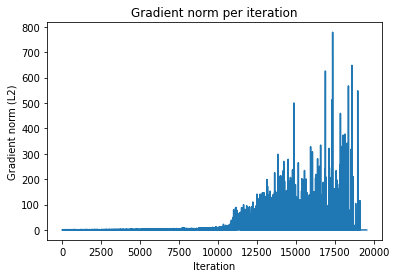

In [9]:
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("Jacobian vector norm (L2)")
plt.title("Jacobian vector norm per iteration")

In [22]:
print(np.max(norms[:10000])); print(np.max(norms)); print(np.max(norms[:11000]))
print(np.mean(norms[:10000]))
print(np.std(norms[:10000]))

12.824639320373535
778.9630737304688
50.662010192871094
1.0627178527846932
1.2274392424986016


As can be seen, we deal with exploding gradients. To mitigate this, we utilize gradient clipping. Specifically, we impose that the norm of the Jacobian vector product must be less than 1.

In [24]:
torch.manual_seed(42) # setting seed for reproducibility

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-6
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.2803077697753906
Test loss in epoch 2: 2.2389345169067383
Test loss in epoch 3: 2.2608096599578857
Test loss in epoch 4: 2.1828293800354004
Test loss in epoch 5: 2.091196060180664
Test loss in epoch 6: 2.085883617401123
Test loss in epoch 7: 1.954644799232483
Test loss in epoch 8: 1.8096802234649658
Test loss in epoch 9: 1.7340152263641357
Test loss in epoch 10: 1.4683746099472046
Test loss in epoch 11: 1.2674752473831177
Test loss in epoch 12: 1.2817819118499756
Test loss in epoch 13: 0.8228669762611389
Test loss in epoch 14: 1.0629976987838745
Test loss in epoch 15: 0.6376643180847168
Test loss in epoch 16: 0.888964831829071
Test loss in epoch 17: 0.882891833782196
Test loss in epoch 18: 1.6762107610702515
Test loss in epoch 19: 0.5479592084884644
Test loss in epoch 20: 0.964219331741333
Test loss in epoch 21: 1.7357947826385498
Test loss in epoch 22: 0.8664765357971191
Test loss in epoch 23: 3.1643218994140625
Test loss in epoch 24: 1.9507195949554443
Test lo

Text(0.5, 1.0, 'Gradient norm per iteration')

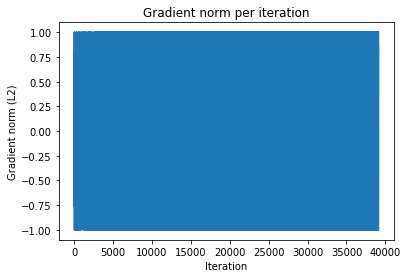

In [14]:
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("Jacobian vector norm (L2)")
plt.title("Jacboian vector norm per iteration")

Backpropagation:

In [17]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
decay = 1e-6
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 50: 0.7351681590080261
Test loss in epoch 50: 0.14682911336421967
Test loss in epoch 50: 0.6396335959434509
Test loss in epoch 50: 0.27114662528038025
Test loss in epoch 50: 0.21662768721580505
Test loss in epoch 50: 0.17748135328292847
Test loss in epoch 50: 0.07071450352668762
Test loss in epoch 50: 0.24497507512569427
Test loss in epoch 50: 0.4674259126186371
Test loss in epoch 50: 0.28199830651283264
Test loss in epoch 50: 0.1205604076385498
Test loss in epoch 50: 0.2431039959192276
Test loss in epoch 50: 0.07322549819946289
Test loss in epoch 50: 0.5181852579116821
Test loss in epoch 50: 0.047042958438396454
Test loss in epoch 50: 0.5721909999847412
Test loss in epoch 50: 0.15358933806419373
Test loss in epoch 50: 0.4720466136932373
Test loss in epoch 50: 0.2051210254430771
Test loss in epoch 50: 0.07038883864879608
Test loss in epoch 50: 0.26860225200653076
Test loss in epoch 50: 0.03980583697557449
Test loss in epoch 50: 0.652442455291748
Test loss in epoch 50

#### Comparing results

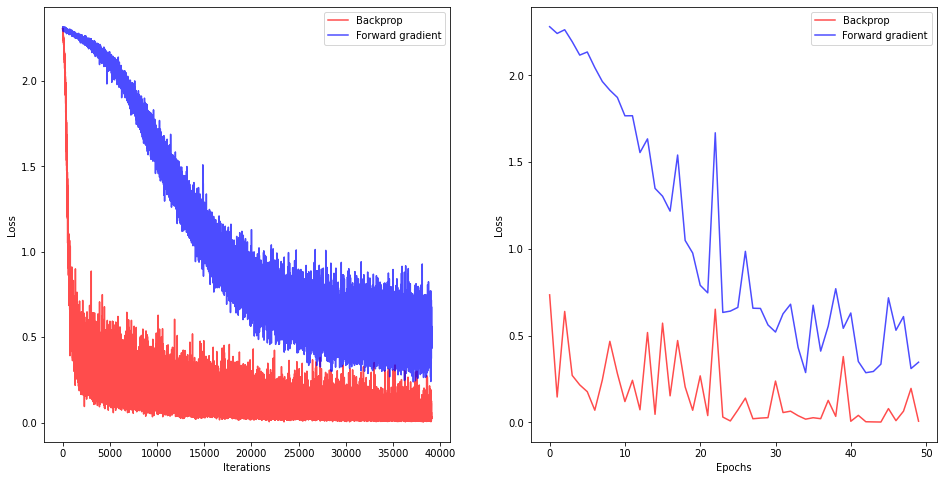

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
momentums = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=0, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000001: 2.3024049260813717
Validation loss for lr = 0.000010, decay = 0.000010: 2.2973024814751497
Validation loss for lr = 0.000010, decay = 0.000100: 2.2996652141498153
Validation loss for lr = 0.000025, decay = 0.000001: 2.294420749518522
Validation loss for lr = 0.000025, decay = 0.000010: 2.291391800922953
Validation loss for lr = 0.000025, decay = 0.000100: 2.2962763840985145
Validation loss for lr = 0.000063, decay = 0.000001: 2.2722129396572233
Validation loss for lr = 0.000063, decay = 0.000010: 2.2714145836556794
Validation loss for lr = 0.000063, decay = 0.000100: 2.2774636350619564
Validation loss for lr = 0.000158, decay = 0.000001: 2.20808955210789
Validation loss for lr = 0.000158, decay = 0.000010: 2.2020661982761065
Validation loss for lr = 0.000158, decay = 0.000100: 2.2419782489728015
Validation loss for lr = 0.000398, decay = 0.000001: 1.348107600667674
Validation loss for lr = 0.000398, decay = 0.000010: 1.52265761080820

Searching for best learning rate and momentum for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-4, -2, 6)
momentums = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net

    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.254
Validation loss for lr = 0.000100, decay = 0.000010: 2.249
Validation loss for lr = 0.000100, decay = 0.000000: 2.250
Validation loss for lr = 0.000251, decay = 0.000001: 2.126
Validation loss for lr = 0.000251, decay = 0.000010: 2.137
Validation loss for lr = 0.000251, decay = 0.000000: 2.123
Validation loss for lr = 0.000631, decay = 0.000001: 1.252
Validation loss for lr = 0.000631, decay = 0.000010: 1.306
Validation loss for lr = 0.000631, decay = 0.000000: 1.279
Validation loss for lr = 0.001585, decay = 0.000001: 0.486
Validation loss for lr = 0.001585, decay = 0.000010: 0.503
Validation loss for lr = 0.001585, decay = 0.000000: 0.492
Validation loss for lr = 0.003981, decay = 0.000001: 0.322
Validation loss for lr = 0.003981, decay = 0.000010: 0.326
Validation loss for lr = 0.003981, decay = 0.000000: 0.323
Validation loss for lr = 0.010000, decay = 0.000001: 0.226
Validation loss for lr = 0.010000, decay = 0.000010: 0.2

### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
momentum = 0.3
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.2803077697753906
Test loss in epoch 2: 2.2389345169067383
Test loss in epoch 3: 2.2608096599578857
Test loss in epoch 4: 2.1828293800354004
Test loss in epoch 5: 2.091196060180664
Test loss in epoch 6: 2.085883617401123
Test loss in epoch 7: 1.954644799232483
Test loss in epoch 8: 1.8109370470046997
Test loss in epoch 9: 1.7350102663040161
Test loss in epoch 10: 1.4522006511688232
Test loss in epoch 11: 1.1871819496154785
Test loss in epoch 12: 1.3281726837158203
Test loss in epoch 13: 0.785765528678894
Test loss in epoch 14: 4.64847469329834
Test loss in epoch 15: 12.214798927307129
Test loss in epoch 16: 11.956789016723633
Test loss in epoch 17: 10.960390090942383
Test loss in epoch 18: 9.963991165161133
Test loss in epoch 19: 11.956789016723633
Test loss in epoch 20: 14.945985794067383
Test loss in epoch 21: 9.963991165161133
Test loss in epoch 22: 11.956789016723633
Test loss in epoch 23: 10.960390090942383
Test loss in epoch 24: 14.945985794067383
Test loss

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
decay = 1e-6
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 50: 0.7351681590080261
Test loss in epoch 50: 0.14682911336421967
Test loss in epoch 50: 0.6396335959434509
Test loss in epoch 50: 0.27114662528038025
Test loss in epoch 50: 0.21662768721580505
Test loss in epoch 50: 0.17748135328292847
Test loss in epoch 50: 0.07071450352668762
Test loss in epoch 50: 0.24497507512569427
Test loss in epoch 50: 0.4674259126186371
Test loss in epoch 50: 0.28199830651283264
Test loss in epoch 50: 0.1205604076385498
Test loss in epoch 50: 0.2431039959192276
Test loss in epoch 50: 0.07322549819946289
Test loss in epoch 50: 0.5181852579116821
Test loss in epoch 50: 0.047042958438396454
Test loss in epoch 50: 0.5721909999847412
Test loss in epoch 50: 0.15358933806419373
Test loss in epoch 50: 0.4720466136932373
Test loss in epoch 50: 0.2051210254430771
Test loss in epoch 50: 0.07038883864879608
Test loss in epoch 50: 0.26860225200653076
Test loss in epoch 50: 0.03980583697557449
Test loss in epoch 50: 0.652442455291748
Test loss in epoch 50

#### Comparing results

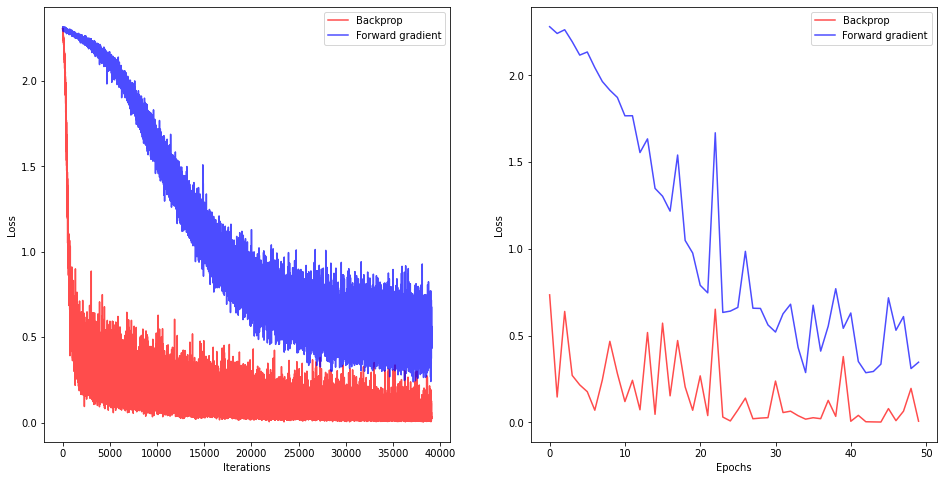

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

# Convolutional Neural Network

We then use a CNN. Code can be found in `models.py`.

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
decays = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000001: 2.3024049260813717
Validation loss for lr = 0.000010, decay = 0.000010: 2.2973024814751497
Validation loss for lr = 0.000010, decay = 0.000100: 2.2996652141498153
Validation loss for lr = 0.000025, decay = 0.000001: 2.294420749518522
Validation loss for lr = 0.000025, decay = 0.000010: 2.291391800922953
Validation loss for lr = 0.000025, decay = 0.000100: 2.2962763840985145
Validation loss for lr = 0.000063, decay = 0.000001: 2.2722129396572233
Validation loss for lr = 0.000063, decay = 0.000010: 2.2714145836556794
Validation loss for lr = 0.000063, decay = 0.000100: 2.2774636350619564
Validation loss for lr = 0.000158, decay = 0.000001: 2.20808955210789
Validation loss for lr = 0.000158, decay = 0.000010: 2.2020661982761065
Validation loss for lr = 0.000158, decay = 0.000100: 2.2419782489728015
Validation loss for lr = 0.000398, decay = 0.000001: 1.348107600667674
Validation loss for lr = 0.000398, decay = 0.000010: 1.52265761080820

Searching for best learning rate and learning rate decay for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-4, -2, 6)
decays = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = ConvNet().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.254
Validation loss for lr = 0.000100, decay = 0.000010: 2.249
Validation loss for lr = 0.000100, decay = 0.000000: 2.250
Validation loss for lr = 0.000251, decay = 0.000001: 2.126
Validation loss for lr = 0.000251, decay = 0.000010: 2.137
Validation loss for lr = 0.000251, decay = 0.000000: 2.123
Validation loss for lr = 0.000631, decay = 0.000001: 1.252
Validation loss for lr = 0.000631, decay = 0.000010: 1.306
Validation loss for lr = 0.000631, decay = 0.000000: 1.279
Validation loss for lr = 0.001585, decay = 0.000001: 0.486
Validation loss for lr = 0.001585, decay = 0.000010: 0.503
Validation loss for lr = 0.001585, decay = 0.000000: 0.492
Validation loss for lr = 0.003981, decay = 0.000001: 0.322
Validation loss for lr = 0.003981, decay = 0.000010: 0.326
Validation loss for lr = 0.003981, decay = 0.000000: 0.323
Validation loss for lr = 0.010000, decay = 0.000001: 0.226
Validation loss for lr = 0.010000, decay = 0.000010: 0.2

### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-6
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.2803077697753906
Test loss in epoch 2: 2.2389345169067383
Test loss in epoch 3: 2.2608096599578857
Test loss in epoch 4: 2.1828293800354004
Test loss in epoch 5: 2.091196060180664
Test loss in epoch 6: 2.085883617401123
Test loss in epoch 7: 1.954644799232483
Test loss in epoch 8: 1.8096802234649658
Test loss in epoch 9: 1.7340152263641357
Test loss in epoch 10: 1.4683746099472046
Test loss in epoch 11: 1.2674752473831177
Test loss in epoch 12: 1.2817819118499756
Test loss in epoch 13: 0.8228669762611389
Test loss in epoch 14: 1.0629976987838745
Test loss in epoch 15: 0.6376643180847168
Test loss in epoch 16: 0.888964831829071
Test loss in epoch 17: 0.882891833782196
Test loss in epoch 18: 1.6762107610702515
Test loss in epoch 19: 0.5479592084884644
Test loss in epoch 20: 0.964219331741333
Test loss in epoch 21: 1.7357947826385498
Test loss in epoch 22: 0.8664765357971191
Test loss in epoch 23: 3.1643218994140625
Test loss in epoch 24: 1.9507195949554443
Test lo

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
decay = 1e-6
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 50: 0.7351681590080261
Test loss in epoch 50: 0.14682911336421967
Test loss in epoch 50: 0.6396335959434509
Test loss in epoch 50: 0.27114662528038025
Test loss in epoch 50: 0.21662768721580505
Test loss in epoch 50: 0.17748135328292847
Test loss in epoch 50: 0.07071450352668762
Test loss in epoch 50: 0.24497507512569427
Test loss in epoch 50: 0.4674259126186371
Test loss in epoch 50: 0.28199830651283264
Test loss in epoch 50: 0.1205604076385498
Test loss in epoch 50: 0.2431039959192276
Test loss in epoch 50: 0.07322549819946289
Test loss in epoch 50: 0.5181852579116821
Test loss in epoch 50: 0.047042958438396454
Test loss in epoch 50: 0.5721909999847412
Test loss in epoch 50: 0.15358933806419373
Test loss in epoch 50: 0.4720466136932373
Test loss in epoch 50: 0.2051210254430771
Test loss in epoch 50: 0.07038883864879608
Test loss in epoch 50: 0.26860225200653076
Test loss in epoch 50: 0.03980583697557449
Test loss in epoch 50: 0.652442455291748
Test loss in epoch 50

#### Comparing results

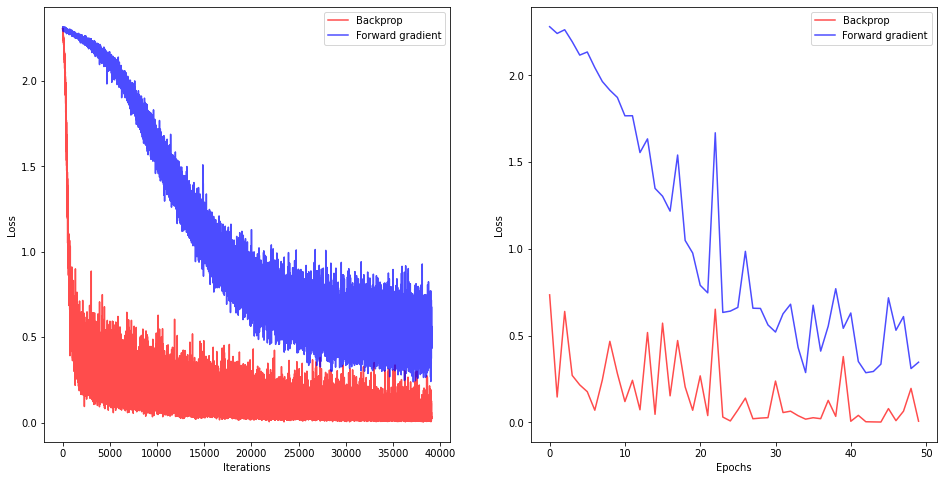

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
momentums = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=0, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000001: 2.3024049260813717
Validation loss for lr = 0.000010, decay = 0.000010: 2.2973024814751497
Validation loss for lr = 0.000010, decay = 0.000100: 2.2996652141498153
Validation loss for lr = 0.000025, decay = 0.000001: 2.294420749518522
Validation loss for lr = 0.000025, decay = 0.000010: 2.291391800922953
Validation loss for lr = 0.000025, decay = 0.000100: 2.2962763840985145
Validation loss for lr = 0.000063, decay = 0.000001: 2.2722129396572233
Validation loss for lr = 0.000063, decay = 0.000010: 2.2714145836556794
Validation loss for lr = 0.000063, decay = 0.000100: 2.2774636350619564
Validation loss for lr = 0.000158, decay = 0.000001: 2.20808955210789
Validation loss for lr = 0.000158, decay = 0.000010: 2.2020661982761065
Validation loss for lr = 0.000158, decay = 0.000100: 2.2419782489728015
Validation loss for lr = 0.000398, decay = 0.000001: 1.348107600667674
Validation loss for lr = 0.000398, decay = 0.000010: 1.52265761080820

Searching for best learning rate and momentum for backpropagation.

In [ ]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-4, -2, 6)
momentums = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net

    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.254
Validation loss for lr = 0.000100, decay = 0.000010: 2.249
Validation loss for lr = 0.000100, decay = 0.000000: 2.250
Validation loss for lr = 0.000251, decay = 0.000001: 2.126
Validation loss for lr = 0.000251, decay = 0.000010: 2.137
Validation loss for lr = 0.000251, decay = 0.000000: 2.123
Validation loss for lr = 0.000631, decay = 0.000001: 1.252
Validation loss for lr = 0.000631, decay = 0.000010: 1.306
Validation loss for lr = 0.000631, decay = 0.000000: 1.279
Validation loss for lr = 0.001585, decay = 0.000001: 0.486
Validation loss for lr = 0.001585, decay = 0.000010: 0.503
Validation loss for lr = 0.001585, decay = 0.000000: 0.492
Validation loss for lr = 0.003981, decay = 0.000001: 0.322
Validation loss for lr = 0.003981, decay = 0.000010: 0.326
Validation loss for lr = 0.003981, decay = 0.000000: 0.323
Validation loss for lr = 0.010000, decay = 0.000001: 0.226
Validation loss for lr = 0.010000, decay = 0.000010: 0.2

### Modeling

We first run forward gradient for the optimal hyperparameters.

In [ ]:
# for reproducible purposes
torch.manual_seed(42)

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
momentum = 0.3
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.2803077697753906
Test loss in epoch 2: 2.2389345169067383
Test loss in epoch 3: 2.2608096599578857
Test loss in epoch 4: 2.1828293800354004
Test loss in epoch 5: 2.091196060180664
Test loss in epoch 6: 2.085883617401123
Test loss in epoch 7: 1.954644799232483
Test loss in epoch 8: 1.8109370470046997
Test loss in epoch 9: 1.7350102663040161
Test loss in epoch 10: 1.4522006511688232
Test loss in epoch 11: 1.1871819496154785
Test loss in epoch 12: 1.3281726837158203
Test loss in epoch 13: 0.785765528678894
Test loss in epoch 14: 4.64847469329834
Test loss in epoch 15: 12.214798927307129
Test loss in epoch 16: 11.956789016723633
Test loss in epoch 17: 10.960390090942383
Test loss in epoch 18: 9.963991165161133
Test loss in epoch 19: 11.956789016723633
Test loss in epoch 20: 14.945985794067383
Test loss in epoch 21: 9.963991165161133
Test loss in epoch 22: 11.956789016723633
Test loss in epoch 23: 10.960390090942383
Test loss in epoch 24: 14.945985794067383
Test loss

Backpropagation:

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
decay = 1e-6
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 50: 0.7351681590080261
Test loss in epoch 50: 0.14682911336421967
Test loss in epoch 50: 0.6396335959434509
Test loss in epoch 50: 0.27114662528038025
Test loss in epoch 50: 0.21662768721580505
Test loss in epoch 50: 0.17748135328292847
Test loss in epoch 50: 0.07071450352668762
Test loss in epoch 50: 0.24497507512569427
Test loss in epoch 50: 0.4674259126186371
Test loss in epoch 50: 0.28199830651283264
Test loss in epoch 50: 0.1205604076385498
Test loss in epoch 50: 0.2431039959192276
Test loss in epoch 50: 0.07322549819946289
Test loss in epoch 50: 0.5181852579116821
Test loss in epoch 50: 0.047042958438396454
Test loss in epoch 50: 0.5721909999847412
Test loss in epoch 50: 0.15358933806419373
Test loss in epoch 50: 0.4720466136932373
Test loss in epoch 50: 0.2051210254430771
Test loss in epoch 50: 0.07038883864879608
Test loss in epoch 50: 0.26860225200653076
Test loss in epoch 50: 0.03980583697557449
Test loss in epoch 50: 0.652442455291748
Test loss in epoch 50

#### Comparing results

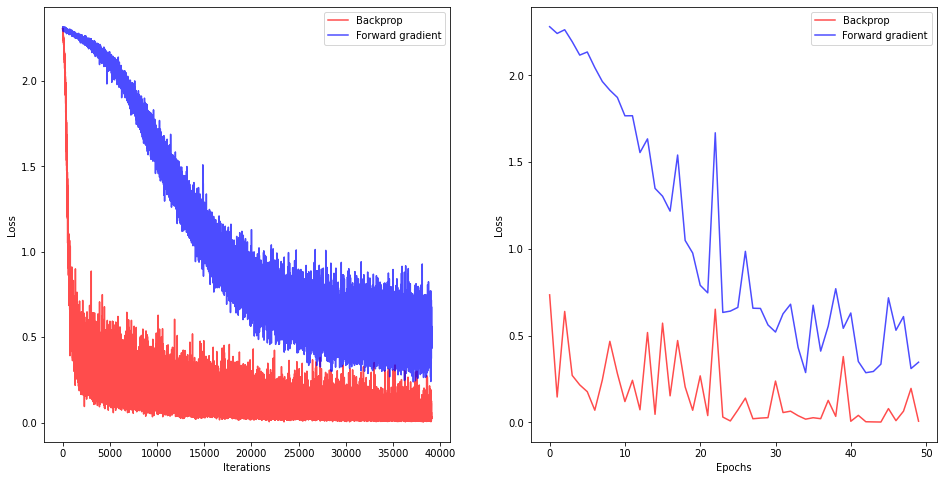

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()